In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from skimage.util import random_noise
from skimage.transform import resize

Loading CIFAR-10 dataset

In [4]:
# We will simulate microstructure with small images

(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 75s 0us/step


In [6]:
x_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [7]:
x_test

array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62352943, 0.43529412, 0.18431373],
         [0.64705884, 0.45490196, 0.2       ],
         ...,
         [0.5372549 , 0.37254903, 0.14117648],
         [0.49411765, 0.35686275, 0.14117648],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.59607846, 0.4392157 , 0.2       ],
         [0.5921569 , 0.43137255, 0.15686275],
         [0.62352943, 0.44705883, 0.1764706 ],
         ...,
         [0.53333336, 0.37254903, 0.12156863],
         [0.49019608, 0.35686275, 0.1254902 ],
         [0.46666667, 0.34509805, 0.13333334]],

        [[0.5921569 , 0.43137255, 0.18431373],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.61960787, 0.43529412, 0.14117648],
         ...,
         [0.54509807, 0.38431373, 0.13333334],
         [0.50980395, 0.37254903, 0.13333334],
         [0.47058824, 0.34901962, 0.12941177]],

        ...,

        [[0.26666668, 0.4862745 , 0.69411767],
         [0.16470589, 0.39215687, 0.5803922 ]

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [19]:
# Resize images to 64x64 

x_train = np.array([resize(img, (64, 64)) for img in x_train[:10000]])
x_test = np.array([resize(img, (64, 64)) for img in x_test[:1000]])

In [20]:
# Add Gaussian noise to simulate distortion

x_train_noisy = random_noise(x_train, mode='gaussian', var=0.01)
x_test_noisy = random_noise(x_test, mode='gaussian', var=0.01)

In [22]:
# Keep pixels in [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [26]:
# Define UNet-based Autoencoder
def build_unet_autoencoder():
    inputs = layers.Input(shape=(64, 64, 3))

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b1)
    concat1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    concat2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

In [28]:
# Compile and train
unet = build_unet_autoencoder()
unet.compile(optimizer='adam', loss='mse')
unet.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_12[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_14[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 384)              │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_16[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 192)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_18[0][0] 

 Total params: 1,883,267 (7.18 MB)

 Trainable params: 1,883,267 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
unet.fit(x_train_noisy, x_train,
         epochs=10,
         batch_size=64,
         shuffle=True,
         validation_data=(x_test_noisy, x_test))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - loss: 6.6342e-04 - val_loss: 6.2476e-04
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - loss: 6.3496e-04 - val_loss: 5.9748e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - loss: 5.9259e-04 - val_loss: 5.7555e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - loss: 5.7398e-04 - val_loss: 5.6230e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 6.0243e-04 - val_loss: 5.4796e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 5.6254e-04 - val_loss: 6.4686e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - loss: 5.6776e-04 - val_loss: 5.3125e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 5.4728e-04 - val_loss: 5.5791e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - loss: 5.4243e-04 - val_loss: 5.3562e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - loss: 5.9977e-04 - val_loss: 5.1958e-04


In [31]:
# Evaluate visually
decoded_imgs = unet.predict(x_test_noisy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step


Display the results

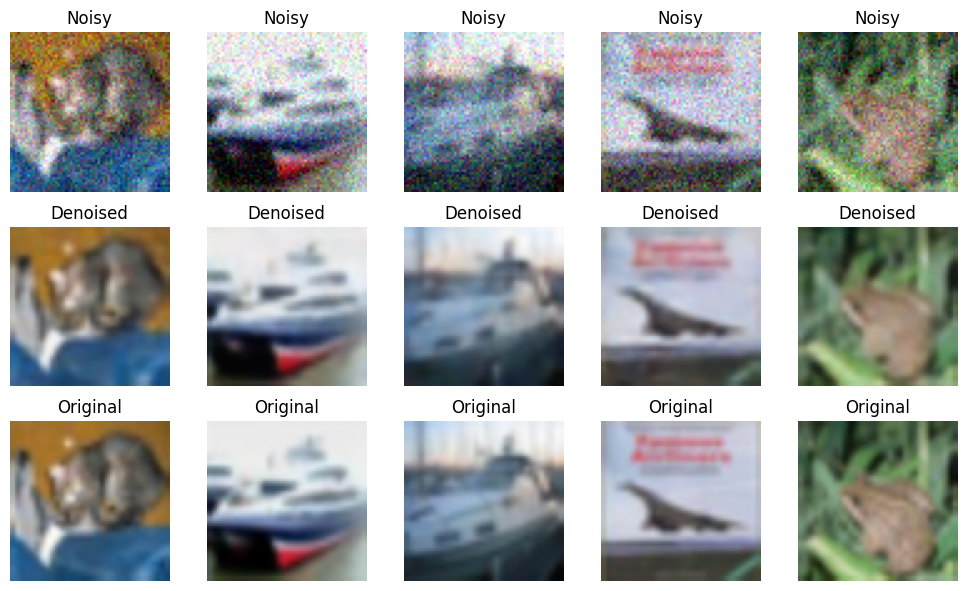

In [32]:
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")
plt.tight_layout()
plt.show()